In [2]:
import sys
import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure
import numpy as np
import pandas as pd
import obspy
from obspy.core import UTCDateTime
from obspy.clients.fdsn.client import Client
from obspy.geodetics import *
from obspy.signal.cross_correlation import *
from obspy.signal.trigger import classic_sta_lta
from obspy.core.utcdatetime import UTCDateTime
import requests
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy import optimize
from scipy.optimize import curve_fit
from geopy import distance
import datetime
import rasterio as rio
from rasterio.plot import show
from rasterio.merge import merge
import richdem as rd
from pathlib import Path
from pyproj import Proj,transform,Geod
import os 

In [3]:
t_before = 120 #number of seconds before pick time
t_after = 600 #number of seconds after pick time
fs = 40 #sampling rate that all waveforms are resampled to
window = 30 #window length of the signal
pr = 98 #percentile
thr = 2 #SNR threshold
station_distance_threshold = 25
pi = np.pi
v_s = 1000 #shear wave velocity at the surface
t_beginning = UTCDateTime(2001,1,1,0,0,0)
t_end = UTCDateTime(2021,12,31,23,59)
smooth_length = 5
low_cut = 2
high_cut = 8
az_thr = 1000 #threshold of distance in meters from source location
step = 100 #step every 100 m
t_step = 1 #step every second
ratio = 5.6915196
colors = list(plt.cm.tab10(np.arange(10)))*3
radius = 6371e3

In [4]:
#define a function that calculates picktimes at each station
def pick_time(time, ref_env, data_env_dict, st, t_diff, t_before, fs):
    pick_times,offsets, starttimes = [],[],[]
    for i,key in enumerate(data_env_dict):
        starttimes.append(st[i].stats.starttime)
        xcor = correlate(data_env_dict[key],ref_env,int(50*fs))
        index = np.argmax(xcor)
        cc = round(xcor[index],9) #correlation coefficient
        shift = 50*fs-index #how much it is shifted from the reference envelope
        offset_time = time - shift/fs
        p = time - shift/fs  # p is the new phase pick for each station
        pick_times.append(p+t_diff[key])
        offsets.append(offset_time + t_diff[key])
    return pick_times, offsets, starttimes
    
def shift(pick_times, offsets, starttimes, t_diff):
    shifts, vals =[],[]
    for i,ii in enumerate(t_diff):
        t_shift = offsets[i]-min(offsets)
        vals.append((-1*t_diff[ii])+t_shift)
        shifts.append(t_shift)
        #plt.vlines(val, ymin = iplot*1.5-.5, ymax = iplot*1.5+.5, color = colors[i])
    return shifts, vals

# define functon that resamples the data
def resample(st, fs):
    for i in st:
        i.detrend(type='demean')
        i.taper(0.05)
        i.resample(fs)   
    return st

# define function to calculate number of surface events per month
def events_per_month(starttimes, events):
    num_events = {}
    for year in range (2001, 2021):
        for month in range (1, 13):
            Nevt = []
            period = str(year)+"_"+str(month)
            t0 = UTCDateTime(year, month, 1)
            t1 = t0+3600*24*30
            for i in range(0, len(starttimes)):
                if t0<starttimes[i]<t1:
                    Nevt.append(events[i])
            if len(Nevt) != 0:
                num_events[period]=len(Nevt)
            if len(Nevt) == 0:
                num_events[period] = 0

    periods = list(num_events.keys())
    num_of_events = list(num_events.values())
    return periods, num_of_events

# define function to fit data to
def test_func(theta, a,theta0, c):
    return a * np.cos(theta-theta0)+c

# define a function to make plots of weighted data
def weight_data(x_data,y_data,weight,test_func,v_s,stas):    
    #weighting the data
    tempx, tempy = [],[]
    for i,ii in enumerate(x_data):
        tempx.append([])
        tempx[i].append([ii for l in range(0,weight[i])])
        tempy.append([])
        tempy[i].append([y_data[i] for l in range(0,weight[i])])   
    weighted_x = sum(sum(tempx, []),[])
    weighted_y = sum(sum(tempy, []),[])
   
    #optimizing parameters to fit weighted data to test_function
    params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(weighted_x), weighted_y, p0=None)
    d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
    if params[0]<0:
        direction = params[1]+pi 
    else:
        direction = params[1]   
    fmax = max(d)
    fmin = min(d)
    v = v_s*((fmax-fmin)/(fmax+fmin))
    return v, direction, d

# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals, weight):
    res = (arrivals - synth_arrivals)*weight 
    res_sqr = res**2
    mse = np.mean(res_sqr)
    rmse = np.sqrt(mse)
    return rmse

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals, weight):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)):
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                synth_arrivals = []
                for h in range(len(sta_x)):
                    tt = travel_time(t0[i],x_vect[j],y_vect[k],vs,sta_x[h],sta_y[h])
                    synth_arrivals.append(tt)
                rss = error(np.array(synth_arrivals),np.array(arrivals), np.array(weight))
                rss_mat[i,j,k] = rss
    return rss_mat

# define function to find lower-left corner of grid and grid size based on height of volcano
def start_latlon(elevation, ratio, center_lat, center_lon):
    side_length = elevation * ratio
    l = side_length/2
    hypotenuse = l*np.sqrt(2)
    d = distance.geodesic(meters = hypotenuse)
    start_lat = d.destination(point=[center_lat,center_lon], bearing=225)[0]
    start_lon = d.destination(point=[center_lat,center_lon], bearing=225)[1]
    return start_lat, start_lon, side_length

# define function to convert the location index into latitude and longitude
def location(x_dist, y_dist, start_lat, start_lon):
    bearing = 90-np.rad2deg(np.arctan(y_dist/x_dist))
    dist = np.sqrt((x_dist)**2 + (y_dist)**2)
    d = distance.geodesic(meters = dist)
    loc_lat = d.destination(point=[start_lat,start_lon], bearing=bearing)[0]
    loc_lon = d.destination(point=[start_lat,start_lon], bearing=bearing)[1]
    return loc_lat, loc_lon, d

# define function to find diameter in meters of the error on the location
def error_diameter(new_array):
    min_idx = np.min(new_array[:,1])
    max_idx = np.max(new_array[:,1])
    difference = max_idx-min_idx
    diameter_m = difference*1000
    return diameter_m 

In [5]:
df = pd.read_csv('Data/Volcano_Metadata_50km.csv')

In [6]:
volc_lat_lon = {}
volc_lat_lon['Mt_St_Helens'] =[46.200472222222224,-122.18883611111112,2549, 10000, 10000, 17000, 15000]
volc_grid = {}
for volc in volc_lat_lon:
    elevation = volc_lat_lon[volc][2]
    center_lat = volc_lat_lon[volc][0]
    center_lon = volc_lat_lon[volc][1]
    start_lat, start_lon, side_length = start_latlon(elevation, ratio, center_lat, center_lon)
    volc_grid[volc] = [start_lat, start_lon, side_length]
    
dem_data_dict = {}
for name in volc_lat_lon:
    if volc_lat_lon[name][0]>46:
        dem = rio.open('Data/DEM_data/'+str(name)+'/'+str(name)+'.tif') #washington volcanoes
        dem_array = dem.read(1).astype('float64')
        dem_array[dem_array == -32767] = np.nan #gets rid of edge effects
        crs = dem.crs
#     volc = rd.rdarray(dem_array, no_data=-9999)
#     slope = rd.TerrainAttribute(volc,attrib = 'slope_riserun')
#     aspect = rd.TerrainAttribute(volc, attrib = 'aspect')
#     dem_data_dict[name] = {'data':dem_array, 'elevation':volc, 'slope':slope, 'aspect':aspect}
    dem_data_dict[name]={'data':dem_array, 'crs':crs, 'left':dem.bounds[0], 'right':dem.bounds[2], 'bottom':dem.bounds[1], 'top':dem.bounds[3]}
    
lat_lon_dict = {}
lat_lon_dict['Mt_Rainier']={'tick_lons':[-121.65, -121.7, -121.75, -121.8, -121.85],
                            'tick_lats':[46.75,46.8,46.85,46.9,46.95]}
lat_lon_dict['Mt_St_Helens']={'tick_lons':[-122.10,-122.15,-122.2,-122.25],
                              'tick_lats':[46.16, 46.18, 46.20, 46.22]}
lat_lon_dict['Mt_Adams']={'tick_lons':[-121.6, -121.55, -121.5, -121.45, -121.4],
                          'tick_lats':[46.16, 46.18, 46.20, 46.22]}
lat_lon_dict['Mt_Baker']={'tick_lons':[ -121.7, -121.75, -121.80, -121.85, -121.90, -121.95],
                          'tick_lats':[48.71, 48.74, 48.77, 48.80, 48.83, 48.86]}
lat_lon_dict['Mt_Hood']={'tick_lons':[-121.58, -121.62, -121.66, -121.70, -121.74],
                         'tick_lats':[45.3, 45.33, 45.36, 45.39, 45.42]}
lat_lon_dict['Glacier_Peak']={'tick_lons':[ -121.07, -121.09, -121.11, -121.13, -121.15],
                              'tick_lats':[48.08, 48.10, 48.12, 48.14, 48.16]}
lat_lon_dict['Newberry']={'tick_lons':[-121.11, -121.15, -121.19, -121.23, -121.27, -121.31, -121.34],
                          'tick_lats':[43.64, 43.67, 43.70, 43.73, 43.76, 43.79, 43.82]}
lat_lon_dict['Crater_Lake']={'tick_lons':[ -121.98, -122.06, -122.14, -122.22, -122.30],
                             'tick_lats':[42.80, 42.85, 42.90, 42.95, 43.00]}



/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr)
/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr)
/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr)
/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr)
/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr)
/tmp/ipykernel_2812918/3500802451.py:48: RuntimeWarning: invalid value encountered in double_scalars
  snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr

28


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

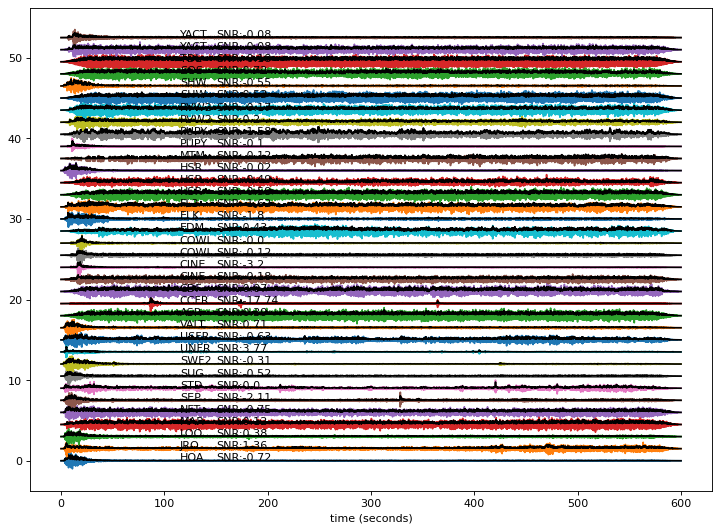

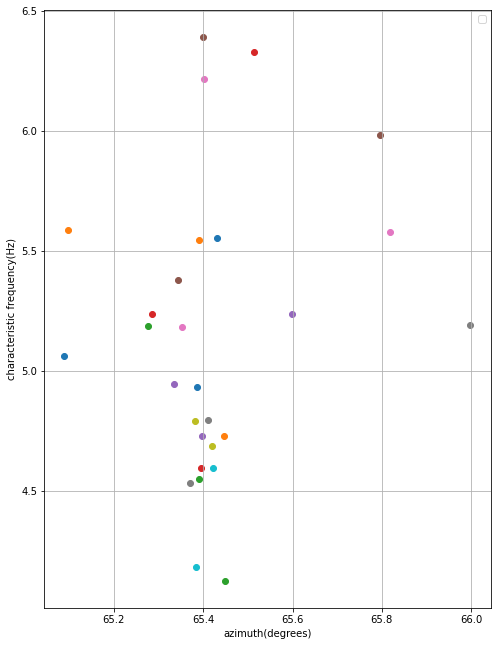

In [8]:
evt_data = pd.DataFrame(columns = ['event_ID','location_latitude','location_longitude','location_uncertainty(m)',
                                   'origin_time','direction(degrees)', 
                                   'direction_sharpness(degrees)','direction_snr(degrees)','duration(sec)',
                                   'params_std_deviation', 'velocity(m/s)','number_of_stations'])

client = Client('IRIS') 

associated_volcano = 'Mt_St_Helens' 
event_ID = str(61916746)
time = UTCDateTime(2023,4,8,9,34,7)

#get info for stations within 50km of volcano that event ocurred at
stations = df[df['Volcano_Name'] == associated_volcano]['Station'].values.tolist()
networks = df[df['Volcano_Name'] == associated_volcano]['Network'].values.tolist()
latitudes = df[df['Volcano_Name'] == associated_volcano]['Latitude'].values.tolist()
longitudes = df[df['Volcano_Name'] == associated_volcano]['Longitude'].values.tolist()
elevations = df[df['Volcano_Name']== associated_volcano]['Elevation'].values.tolist()
 

reference = str(networks[0]+'.'+stations[0])
bulk = []
for m in range(0,len(stations)):
    bulk.append([networks[m], stations[m], '*', '*', time, time+t_after])

st = client.get_waveforms_bulk(bulk)

#resampling the data to 40Hz for each trace
st = resample(st,fs) 

#Plotting all traces for one event with channel z, SNR>10, and bandpasses between 2-12Hz
SNR,SNR_weight, stas,nets,max_amp_times,durations,data_env_dict,t_diff = [],[],[],[],[],[],{},{}
fig = plt.figure(figsize = (11,8), dpi=80)

ax1 = plt.subplot(1,1,1)
iplot = 0
for i,ii in enumerate(st):
    network = ii.stats.network
    station = ii.stats.station
    ii.detrend(type = 'demean')
    ii.filter('bandpass',freqmin=2.0,freqmax=12.0,corners=2,zerophase=True)
    cha = ii.stats.channel
    starttime = ii.stats.starttime
    max_amp_time = np.argmax(ii.data)/fs
    signal_window = ii.copy()
    noise_window = ii.copy()
    signal_window.trim(starttime + t_before - 20, starttime + t_before - 20 + window)
    noise_window.trim(starttime + t_before - window -10, starttime + t_before - 10)
    snr = (20 * np.log(np.percentile(np.abs(signal_window.data),pr) 
                   / np.percentile(np.abs(noise_window.data),pr))/np.log(10))

    if cha[-1] == 'Z':
        t = ii.times()
        t_diff[network+'.'+station] = starttime-time 
        stas.append(station)
        nets.append(network)
        SNR.append(snr)
        SNR_weight.append(int(snr))
        # enveloping the data 
        data_envelope = obspy.signal.filter.envelope(ii.data)
        data_envelope /= np.max(data_envelope)
        data_envelope += iplot*1.5
        # finding the time of max amplitude of each event
        max_amp_times.append(max_amp_time)
        max_amp = np.max(ii.data)      
        # creating envelope data dictionary to calculate picktimes
        data_envelope = obspy.signal.util.smooth(data_envelope, smooth_length)
        data_env_dict[network+'.'+station]= data_envelope
        ax1.plot(t,ii.data/np.max(np.abs(ii.data))+iplot*1.5)
        ax1.plot(t, data_envelope, color = 'k')
        ax1.set_xlabel('time (seconds)')
        plt.text(t[150*fs], iplot*1.5, 'SNR:'+str(round(snr,2)))
        plt.text(t[115*fs], iplot*1.5, station)
        iplot = iplot+1

    else:
        st.remove(ii)

remove = []
for i in range(len(stas)):
    if stas[i] == stas [i-1]:
        remove.append(int(i))

for index in sorted(remove, reverse=True):
    del stas[index]
    del nets[index]
    del SNR[index]
    del SNR_weight[index]
    st.remove(st[index])

# get peak frequency of each event
# read and preprocess data
st.taper(max_percentage=0.01,max_length=20)
st.trim(starttime=time-20,endtime=time+30) 

print(len(st))
# make plot of spectra
char_freq, sharp_weight= [],[]
for i in range(len(stas)):
    data = st.select(station=stas[i])[0].data*100
    f,psd=scipy.signal.welch(data,fs=st[0].stats.sampling_rate,nperseg=81,noverlap=1)
    #just get the frequencies within the filter band
    above_low_cut = [f>low_cut]
    below_high_cut = [f<high_cut]
    in_band = np.logical_and(above_low_cut,below_high_cut)[0]
    f = f[in_band]
    psd = psd[in_band]

    # calculate characteristic frequency and report
    char_freq_max = f[np.argmax(psd)]
    char_freq_mean= np.sum(psd*f)/np.sum(psd)
    psd_cumsum = np.cumsum(psd)
    psd_sum = np.sum(psd)
    char_freq_median = f[np.argmin(np.abs(psd_cumsum-psd_sum/2))]
    char_freq.append(char_freq_mean)

    # weighting the data by the spikiness of the PSD vs frequency graphs
    ratio = (np.mean(psd)/np.max(psd))
    sharp_weight.append(int(1/(ratio**2)*20))

lats, lons, elevs, r, theta = ([] for i in range(5)) 
ref = str(networks[0]+'.'+stas[0])
try:
    ref_env = data_env_dict[reference]
except:
    ref_env = data_env_dict[ref]



# calculating the picktimes and shift in arrival times using envelope cross_correlation
pick_times, offsets, starttimes = pick_time(time, ref_env, data_env_dict,st,t_diff, t_before, fs) #calculate picktimes
shifts, vals = shift(pick_times, offsets, starttimes, t_diff)


for i in range(len(stas)):
    max_amp_time = max_amp_times[i]
    duration = (max_amp_time-vals[i])*2
    a = stations.index(stas[i])
    lats.append(latitudes[a])
    lons.append(longitudes[a])
    elevs.append(elevations[a])

loc_lat = 55.325
loc_lon = 157.841

# calculating azimuth for each station with respect to the middle of the volcano
for i in range(len(stas)):
    u,b,c = (gps2dist_azimuth(loc_lat, loc_lon, lats[i], lons[i], a=6378137.0, f=0.0033528106647474805))
    r.append(u)
    theta.append(b)

bin1,bin2,bin3 = [],[],[]
for i in theta:
    if 0<=i<=120:
        bin1.append(i)
    if 121<=i<=240:
        bin2.append(i)
    if 241<=i<=360:
        bin3.append(i)

# if bin1 == [] or bin2 == [] or bin3 == []:
#     continue
#manipulating the data
data = {'azimuth_deg':theta, 'freq':char_freq, 'station':stas, 'distance_m':r, 
        'weight':sharp_weight, 'SNR':SNR, 'colors':colors[0:len(stas)]}
DF = pd.DataFrame(data, index = None)
DF2 = DF.sort_values('azimuth_deg')

#Taking out stations that are too close to the location when looking at azimuth 
drops = []
for i in range(len(DF2)):
    value = DF2.loc[i,'distance_m']
    if value < az_thr:
        drops.append(i)
DF3 = DF2.drop(drops)
y_data =  DF3["freq"].values.tolist()
Sta2 = DF3["station"].values.tolist()
dist2 = DF3["distance_m"].values.tolist()
spike_weight = DF3["weight"].values.tolist()
SNR2 = DF3['SNR'].values.tolist()
colors2 = DF3['colors'].values.tolist()
x_data =  np.asarray(DF3["azimuth_deg"].values.tolist())
x_points = np.linspace(0,360, 100)

fig,ax = plt.subplots(1,1,figsize=(8,11))      
ax.set_ylabel('characteristic frequency(Hz)')
ax.set_xlabel(('azimuth(degrees)'))
for i in range (0,len(Sta2)):
    ax.scatter(x_data[i], y_data[i])

ax.legend(loc='upper right', fontsize = 10)
plt.grid(True)

#optimizing parameters to fit data to test_function
params, params_covariance = optimize.curve_fit(test_func, np.deg2rad(x_data), y_data, p0=None)
perr = np.sqrt(np.diag(params_covariance))
std_deviation = str(round(perr[0],9))+','+str(round(perr[1],9))+','+str(round(perr[2],9))
d = test_func(np.deg2rad(x_points), params[0], params[1], params[2])
len_r = int(max(r))

if params[0]<0:
    direction = params[1]+pi 
else:
    direction = params[1]

fmax = max(d)
fmin = min(d)
v = v_s*((fmax-fmin)/(fmax+fmin))

# weight the data
title = 'Sharpness'
v_sharp,direction_sharp,d_sharp = weight_data(x_data,y_data,sharp_weight,test_func,v_s,stas)
 

title = 'SNR'
v_snr,direction_snr,d_snr = weight_data(x_data,y_data,SNR_weight,test_func,v_s,stas)  


fig,ax = plt.subplots(1,1,figsize=(8,11))
fig.suptitle('Fitted Cosine Curves')       
ax.set_ylabel('characteristic frequency(Hz)')
ax.set_xlabel(('azimuth(degrees)'))
for i in range (0,len(Sta2)):
    ax.scatter(x_data[i], y_data[i], s = (SNR_weight[i]**2),label=Sta2[i], color = colors2[i])
ax.plot(x_data,y_data, '--', label='rawdata')
ax.plot(x_points, d, label = 'original')
ax.plot(x_points, d_sharp, label = 'sharpness')
ax.plot(x_points, d_snr, label = 'snr')
ax.legend(loc='upper right', fontsize = 10)
plt.grid(True)


print('calculated velocity is',v)
print('calculated flow direction is', direction )
